机器学习 | 高斯混合模型还能这样预测新冠发病人数与位置

> 关键词：机器学习 / GMM / 高斯混合

>摘要：
机器学习算法有很多种分类维度，最出名且常用的一种分类就是 `判别模型` 与 `生成模型`，这两类模型最主要的区别就是除了预测之外，生成模型还能生成数据，而判别模型则不行！这回小编将利用生成模型的特性，根据现有数据来预测新冠在未来的潜在案发地点，非常适合数据分析与仿真优化的同学们借鉴！

# 简介
高斯混合模型（Gaussian Mixture Model - GMM）是一种非监督的聚类算法，通过寻找数据内部的潜在分布形状，并不断迭代更新分布的参数，逐渐拟合出数据的群聚特征。然而，实现聚类之前，我们的处境恰巧诠释了 `一问三不知` 的情形：
1. 不知道有几个分布
2. 不知道分布长什么样子
3. 不知道分布的参数

而这些所谓的 `不知` 又恰巧能够通过一系列假设被另一个经典算法：`EM 算法` 所描述成隐变量，并巧妙的估计分布的参数值，进而实现聚类算法的效果。EM算法的全名叫做 Expectation-Maximization 算法，目标函数没有办法直接被计算出来的主要原因在于某些信息的丢失，当信息种类与未知参数种类数量不匹配的时候就容易发生这类情况，因此高斯混合模型的实践需要包含下面多个假设：
1. 假设我们已经知道有几个分布
2. 假设我们知道所有分布的种类都属于高斯分布

如此一来，GMM 算法才能顺利运行！

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 场景建模 - 地图
开始聚类算法之前，首先应用场景得先搭建起来，为了贴近真实世界，小编根据深圳地铁的地铁站经纬度完整重现了深圳地铁的走线地图，经纬度获取方法其实百度已经提供了 API 接口，实际操作往下接着看：

In [19]:
import requests

def baidu_api(address):
    former = 'http://api.map.baidu.com/geocoding/v3/?address='
    later = '&output=json&ak=mQ4gwBXA5eLrCwyAd4zhcMsdIVDWmrAW&callback=showLocation'
    return former + address + later

print(requests.get(baidu_api('深圳北站')).text)

showLocation&&showLocation({"status":0,"result":{"location":{"lng":114.03552911268908,"lat":22.615107645742687},"precise":0,"confidence":50,"comprehension":100,"level":"火车站"}})


因此只要找全了所有地铁站的清单，一个循环过后聪明的你也能得到一个完整的地铁走线地图！而且同样方法可应用到任何城市，方便得很！

In [2]:
mrt = pd.read_csv('MRT_loc.csv')

In [3]:
def MRTmap(lw):
    plt.figure(figsize=(12, 8))
    plt.plot(mrt[mrt['line'] == 1]['longitude'].values,
             mrt[mrt['line'] == 1]['latitude'].values, c='green', lw=lw)
    plt.plot(mrt[mrt['line'] == 2]['longitude'].values,
             mrt[mrt['line'] == 2]['latitude'].values, c='#EF4836', lw=lw)
    plt.plot(mrt[mrt['line'] == 3]['longitude'].values,
             mrt[mrt['line'] == 3]['latitude'].values, c='#19B5FE', lw=lw)
    plt.plot(mrt[mrt['line'] == 4]['longitude'].values,
             mrt[mrt['line'] == 4]['latitude'].values, c='red', lw=lw)
    plt.plot(mrt[mrt['line'] == 5]['longitude'].values,
             mrt[mrt['line'] == 5]['latitude'].values, c='purple', lw=lw)
    plt.plot(mrt[mrt['line'] == 7]['longitude'].values,
             mrt[mrt['line'] == 7]['latitude'].values, c='blue', lw=lw)
    plt.plot(mrt[mrt['line'] == 9]['longitude'].values,
             mrt[mrt['line'] == 9]['latitude'].values, c='gray', lw=lw)
    plt.plot(mrt[mrt['line'] == 11]['longitude'].values,
             mrt[mrt['line'] == 11]['latitude'].values, c='brown', lw=lw)

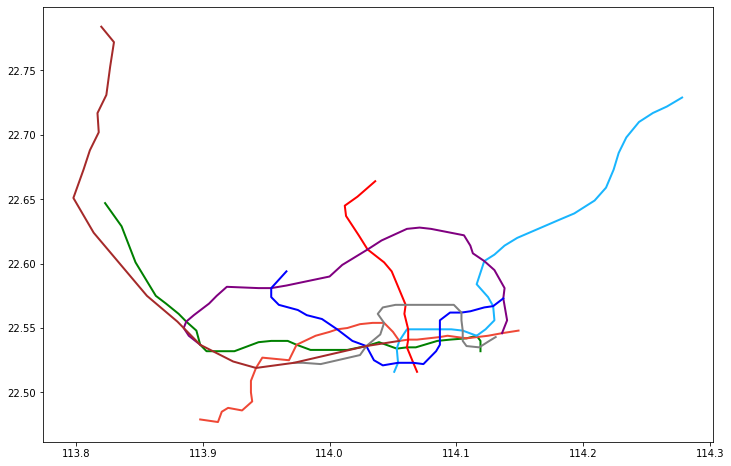

In [20]:
MRTmap(2)
plt.show()

# 场景建模 - 病例位置
具体的病例位置最简单的方法可以通过模拟直接得到，不过幸运的是小编在数据集尚未被停止查询之前就已经保存了好几个重点城市的历史数据，其中就包括深圳的数据！**更多的城市数据小编也上传到了GitHub，订阅了公众号之后就知道 GitHub 网址！** 因此通过经纬度的查询，我们同样可以精准描绘这些位置与地铁站之间的距离和聚集关系！

In [ ]:
sz = pd.read_csv('covid_深圳市.csv')

x1 = sz[sz['latitude'] < 24]['longitude'].values
x2 = sz[sz['latitude'] < 24]['latitude'].values
X = np.vstack([x1, x2]).T

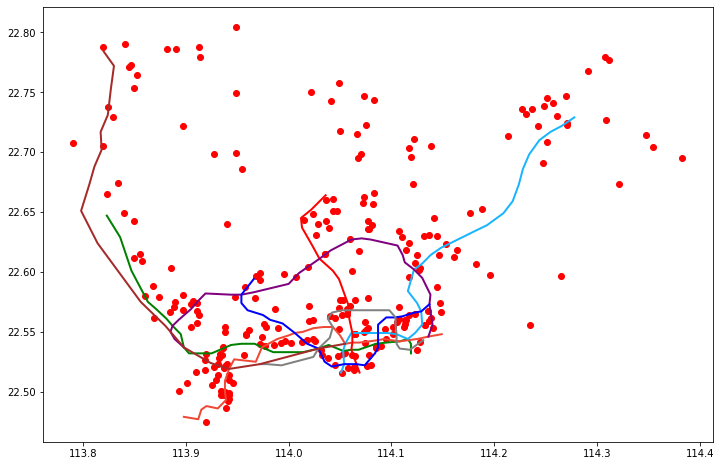

In [21]:
MRTmap(2)
plt.scatter(X[:, 0], X[:, 1], c='red')
plt.show()

# 重头戏 - 高斯混合模型拟合
有了数据，有了地图，接下来就能通过算法来估计这些数据所对应的分布参数！这次文章不着重在 GMM 算法的细节原理讲解上，数学解析将在别期分享中娓娓道来，因此小编就直接上模块，给大家分享算法应用的全流程！

In [5]:
from GMM import *

高斯混合模型当中有以下几个至关重要的参数需要理解，上面 import 的 GMM 模块是小编自己实现的高性能算法，为了方便学习，参数名称一律对齐 `sklearn`：
1. n_components=6
2. max_iter=80
3. tol=1e-4
4. scipy=True

第一个参数专门用来解决 `#简介` 环节中的第一个问题，不知道有几个分布，因此我们假设自己知道就是 6 个，设定成其他的当然也没问题，端看自己的需求和数据分布情况。

第二个参数设定了一个截止条件，由于 GMM 是基于 EM 算法实现分布的参数估计，因此我们需要一些条件来停止参数估计的迭代过程，当更新次数超过 80 次，不论当前更新到什么状态了就一律停止更新。

第三个参数同样是一个截止条件，不过它是从另一个角度来诠释更新的过程，也就是前一次的更新与后一次的更新之间所计算出来的二阶范数小于这个值，那么我们就可以认为它没有继续更新的必要，因此同样停止更新。

第四个参数就是小编自己在 from scratch 过程中添加的一个参数，也可以看成是一个开关，如果打开了（True）则 GMM 训练过程中所生成的高斯分布将通过 `scipy` 所提供的函数来完成，反之则是通过自己构建的高斯分布函数，具体差别只在于速度， `scipy` 代码经过他们团队深度优化后，大量数据的计算与生成也不需要几毫秒就能完成，如果面临庞大数据集，打开开关将是一个好的选择！

理解了这些原理之后，接下来就能直观的启动算法：

In [7]:
gmm = GaussianMixtureModel(n_components=6,
                           max_iter=80,
                           tol=1e-4, scipy=True)

由于 GMM 是一个非监督模型，因此在拟合数据的过程中并不需要标签的参与：

In [8]:
gmm.fit(X)

Totally 80 iters


完成拟合之后， `gmm` 实例里面属性就会有估计的均值 `gmm.means_` 与方差 `gmm.covars_` 矩阵，为了更好的可视化拟合的结果，小编用了多层同心椭圆形来呈现拟合结果，为此构建了以下可视化函数：

In [6]:
def visualization(gmm, X, label=True, ax=None):
    MRTmap(4)
    ax = ax or plt.gca()

    if label:
        ax.scatter(X[:, 0], X[:, 1], c=gmm.predict(X),
                   edgecolors='black', linewidth=0.5,
                   s=40, cmap='Paired', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2,
                   edgecolors='black', linewidth=0.5)

    ax.axis('equal')
    # Setup transparency.
    # w_factor = 0.4 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, fill=False, edgecolor='r', lw=1)

    plt.show()

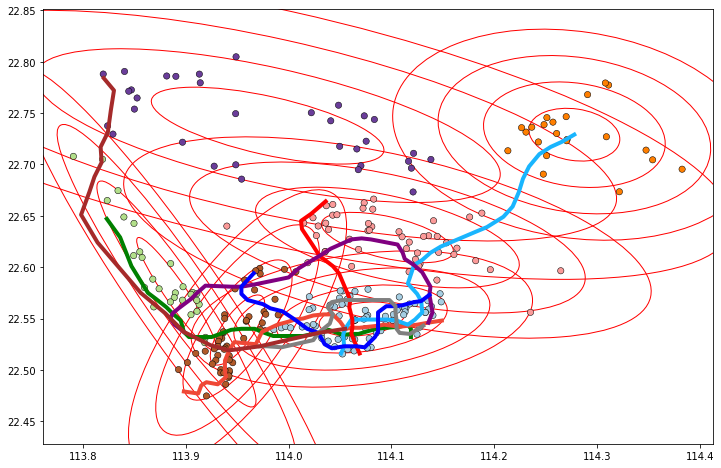

In [9]:
visualization(gmm, X)

>小小提示：
由于画出同心椭圆需要 GMM 拟合后的参数支持，因此在把 `gmm` 实例放入绘图函数之前，必须先经过 `.fit()` 的过程才能顺利画图！

# 数据生成 - 预测病发点
开篇小编就提到 GMM 是一个生成模型，因此它可以用来生成数据，而生成数据的基础就是这些估计出来的参数。现在我们的数据都拟合好了，可以进入到最后一个生成数据的阶段！

根据上面拟合的参数来看，我们一共得到了 6 个高斯模型，生成数据的过程就可以是随机挑选 6 个当中的其中一个分布，根据这个分布的参数生成随机变量并保存到一个矩阵当中，具体操作看代码！

In [10]:
# 生成一个能用来保存 30 个坐标点的矩阵
points = np.zeros([30, 2])
# 对于每一个点做以下事情
for i in range(points.shape[0]):
    # 随机挑选其中一个分布
    n = np.random.randint(0, len(gmm.means_))
    # 根据该分布的 mean 和 covar 生成一组高维的高斯数据并保存到矩阵中
    points[i] = np.random.multivariate_normal(
        gmm.means_[n], gmm.covars_[n], 1)[0]

顺利运行完这步之后，数据生成就算大功告成啦！接下来可以看看数据生成的可视化结果，检查是否符合我们的预期，也观察数据是否生成的有违和感。

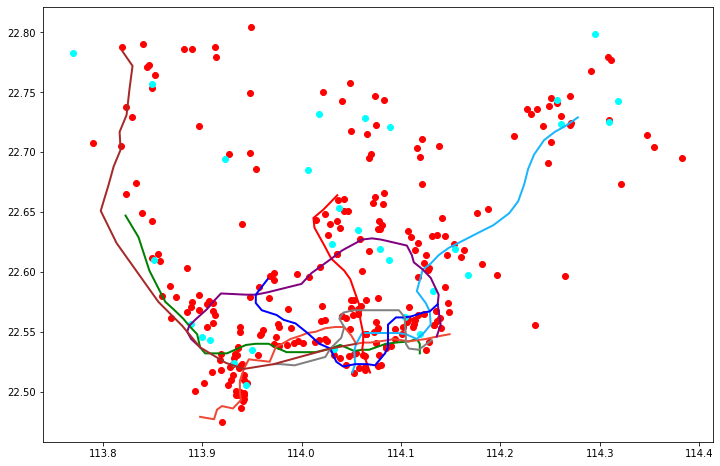

In [13]:
MRTmap(2)
plt.scatter(sz[sz['latitude'] < 24]['longitude'].values,
            sz[sz['latitude'] < 24]['latitude'].values, c='red')
plt.scatter(points[:, 0], points[:, 1], c='cyan')
plt.show()

从结果看，青色的点就是那新的 30 比数据，而红色则是原来的数据，数据生成的位置符合分布状况，因此 GMM 算法也适合用来辅助仿真与统计！